## Import dependencies

In [1]:
# Import all the module dependencies of this script
import json
import pandas
import getpass
import requests
import sys
import msrest

# Import the python autorest wrappers
from emsapi import emsapi

### System Configuration / Constants

In [2]:
# The URL of EFOQA EMS API
api_url = "https://ems.efoqa.com/api/"

### Gather User Credentials
One day we could pull them from a credential store or key vault.

In [3]:
# Query the user for the credentials for the ems.efoqa.com website.
efoqa_user = input('Enter your EFOQA username: ')
efoqa_pass = getpass.getpass(prompt = 'Enter your EFOQA password: ')

### API Session set up

In [4]:
# Authenticates with EMS API using the credentials entered above. 

# This step will call into api and retrieve a bearer token which will be used in subsequent calls.
authorizationUrl = api_url + "token"
body = "grant_type=password&username=" + efoqa_user +"&password=" + efoqa_pass
authorizationResponse = requests.post(authorizationUrl, body)

# Describe the results of the test
if authorizationResponse.ok:
    print("Successfully authenticated with the EMS API and retrieved a bearer token.")
else:
    print("Unable to authenticate with the EMS API.")
    
# Set up the autorest session with the basic authentication type using bearer token.
from msrest import authentication
session = authentication.BasicTokenAuthentication(json.loads(authorizationResponse.text))
myapi = emsapi(session, api_url)

Successfully authenticated with the EMS API and retrieved a bearer token.


### Query API for EMS Systems

In [6]:
# Print the systems the user has access to in order to demonstrate the API.
systems = myapi.ems_system.get_ems_systems()

# Create a list out of the systems list that contains only the information we want.
sysList = list(map(lambda system: [system.id, system.name, system.description], systems))
df = pandas.DataFrame(sysList,columns=['id', 'name', 'description'])

print("You have access to the following systems:")
df

You have access to the following systems:


,id,name,description
0,1,EMS11-APP,The Engine Services server which hosts QAR data.
1,3,EMS10-TEST,The Engine Services system which hosts engine ...
2,5,EMS7-APP,"This is EMS7, which is the eFoqa demo system c..."
3,7,EMS9-APP,EMS9-APP (FES)
4,11,EMS1-APP,Multiple Customers
5,13,EMS15-APP,United Express (UAX)
6,15,EMS20-APP,NetJets (EJA)
7,16,EMS22-APP,Bristow (BHL)
8,17,EMS19-APP,Jetstar (JST)
9,19,EMS13-APP,Virgin Australia (VOZ)


### Query API for time-series data

Let's pull a little bit of data. We'll pick 'baro-corrected altitude' for a particular flight on the demo system. We'll extract 100 points evenly spread through the entire flight.

The altitudeId value below was obtained by using the REST explorer to search for the parameter on EMS Online https://ems.efoqa.com/Docs/Rest/Explorer

The output of this block of code should be an altitude chart that looks familiar.

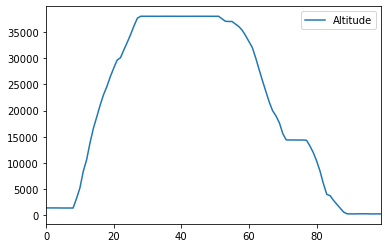

In [7]:
# Baro-corrected altitude
altitudeId = "H4sIAAAAAAAEAG2Q0QuCMBDG34P+B/HdbZVUiApBPQT2kgi9rrn0YM7aZvbnN5JVUvdwfHD34/vu4iPXrbjTs+D7kksDF+DKezRC6ggSvzbmGmHc9z3qF6hVFZ4TMsOnQ5azmjc0AKkNlYz7A/Mm9GusUUkNZa00ijLj+BCTFd6UgApF/XQ68bx4SMHVvkyd1GjX6KytgFER46+FEZBfObOZ2db6eBBJEIlvVGfz4P+LhYRbZ29NyVCzgJD1MgitDIhrrj6+P/h04obj36VPLpuOeVIBAAA="
# A flight that is known to exist
flightId = 190
# EMS7 - the demo system.
emsId = 5
# Pull out altitude with 100 samples through the file.
query = {
    "select": [
    {
      "analyticId": altitudeId
    }
  ],
  "size": 100
}

# Execute the API call.
altitude = myapi.analytic.get_query_results(emsId, flightId, query)
# Offsets accessible using altitude.offsets

# Create a new data frame with the altitude in it.
altitudeDataFrame = pandas.DataFrame();
altitudeDataFrame["Altitude"] = altitude.results[0].values
line = altitudeDataFrame.plot.line()